<a href="https://colab.research.google.com/github/mtodisco10/NLP_Disaster_Tweets/blob/master/NLP_Disaster_Tweets_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
pd.DataFrame({'count': train.target.value_counts(), 
              'percentage': train.target.value_counts(normalize=True)})

,count,percentage
0,4342,0.57034
1,3271,0.42966


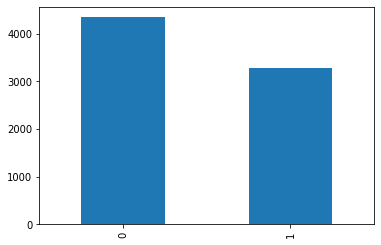

In [4]:
train["target"].value_counts().plot(kind='bar')

In [5]:
def map_keywords(series):
    mapper = {}
    u_series = series.unique()
    for i in range(len(u_series)):
        mapper[u_series[i]] = i
        
    return mapper

train_keyword_map = map_keywords(train.keyword)

train['keyword_num'] = train['keyword'].map(train_keyword_map)
test['keyword_num'] = test['keyword'].map(train_keyword_map)

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
def text_preprocessing(data):
    #remove whitespace and lower all words
    data = data.apply(lambda x: x.strip().lower())
    #replace digits
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    #replace punctuation
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    #tokenize
    data = data.apply(lambda x : word_tokenize(x))
    #filter out stopwords
    data = data.apply(lambda x: [word for word in x if word not in stop_words])
    #remove inflection and return base word
    lemmatizer = WordNetLemmatizer()
    data = data.apply(lambda x: [lemmatizer.lemmatize(word, pos ='v') for word in x])
    #parts of speech tagging
    #data = data.apply(lambda x: [pos_tag(x)])
    return data

train['pro_text'] = text_preprocessing(train.text)
test['pro_text'] = text_preprocessing(test.text)

In [8]:
vectorizer = TfidfVectorizer()
#joining words and fit transofrming
vector = vectorizer.fit_transform(["".join(i) for i in train["pro_text"]])
vector = vector.todense()
vector = np.concatenate((vector, np.reshape(np.array(train["keyword_num"]), (train.keyword.shape[0],-1))), axis=1)
print(vector.shape)

# vector_test = vectorizer.fit_transform(["".join(i) for i in test["text"]])
vector_test = vectorizer.transform(["".join(i) for i in test["pro_text"]])
vector_test = vector_test.todense()
vector_test = np.concatenate((vector_test, np.reshape(np.array(test["keyword_num"]), (test.keyword.shape[0],-1))), axis=1)
print(vector_test.shape)

(7613, 8037)
(3263, 8037)


In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(vector, train['target'], train_size = 0.75)

In [10]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 12.1 s, sys: 2.12 s, total: 14.2 s
Wall time: 13.9 s


In [11]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [13]:
from bert import tokenization

In [16]:
tf.gfile = tf.io.gfile
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
train_input = bert_encode([" ".join(i) for i in train.pro_text], tokenizer, max_len=160)
test_input = bert_encode([" ".join(i) for i in test.pro_text], tokenizer, max_len=160)

In [19]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    
    return model

In [20]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss',mode='auto', baseline=None, restore_best_weights=False)
train_history = model.fit(
    train_input, train.target,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early], verbose=1
)

model.save('model.h5')

Epoch 1/100
147/381 [==========>...................] - ETA: 5:54 - loss: 0.5377 - accuracy: 0.7449